## Training the Gesture/Action Recognition Model:

### In this section we will be training the gesture detection model and we will try to achieve a good accuracy for            the model.

In [1]:
"""
    Import all the important required Deep Learning Libraries to train the gestures model.
    
    Keras is an Application Programming Interface (API) which can run on top of tensorflow.
    
    tensorflow will be the main deep learning module we will use to build our deep learning model.
    
    from tensorflow we will be referring to a pre-trained model called VGG-16. We will be 
    using VGG-16 with custom convolutional neural networks (CNN's) i.e. We will be using 
    our transfer learning model VGG-16 alongside our own custom model to train an overall 
    accurate model. The VGG-16 model in keras is pretrained with the imagenet weights.
    
    The ImageDataGenerator is used for Data augmentation where the model can see more copies of 
        the model. Data Augmentation is used for creating replications of the original images 
        and using those transformations in each epoch.
        
    The layers for training which will be used are as follows:
    1. Input = The input layer which we pass the input shape.
    2. Conv2D = The Convoluional layer combined with Input to provide a output of tensors
    3. Maxpool2D = Downsampling the Data from the convolutional layer.
    4. Batch normalization = It is a technique for training very deep neural networks that standardizes 
       the inputs to a layer for each mini-batch. This has the effect of stabilizing the learning 
       process and dramatically reducing the number of training epochs required to train deep networks.
    5. Dropout = Dropout is a technique where randomly selected neurons are ignored during training. 
                 They are “dropped-out” randomly and this prevents over-fitting.
    6. Dense = Fully Connected layers.
    7. Flatten = Flatten the entire structure to a 1-D array.
    
    The Models can be built in a model like structure as shown in this particular model or can be built 
        in a sequential manner.
        
    Use of l2 regularization for fine tuning.
    
    The optimizer used will be Adam as it is performs better than the other optimizers on this model.
    
    We are also importing the os module to make it compatible with the windows environment. 

"""

import keras
import tensorflow as tf
from tensorflow.keras.applications import VGG16
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Input, Conv2D, MaxPool2D, Dropout, BatchNormalization, Dense, Flatten
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam
import os

Using TensorFlow backend.


In [2]:
"""
    We have 4 classes of gestures which is namely punch, Victory, Super 
    and Loser.
    
    Each of the images have a height and width of 200 as well as it is a 
    RGB image i.e. a 3-Dimensional image.
    
    We will be using a batch_size of 128 for the image Data Augmentation.

"""

num_classes = 4

Img_Height = 200
Img_width = 200

batch_size = 128

In [3]:
"""
    Specify the train and the validation directory for the stored images.
    train_dir is the directory which will contain the set of images for training.
    validation_dir is the directory will contain the set of validation images.

"""

train_dir = "train1"
validation_dir = "validation1"

### Data Augmentation of images:

In [4]:
"""
    Reference: https://keras.io/api/preprocessing/image/
    
    The ImageDataGenerator is used for data augmentation of images. 
    We will be replicating and making copies of the transformations of the
    original images. The Keras Data Generator will use the copies and
    not the original ones. This will be useful for training at each epoch.
    
    We will be recaling the image and updating all the parameters to suit our model
    1. rescale = Rescaling by 1./255 to normalize each of the pixel values
    2. rotation_range = specifies the random range of rotation
    3. shear_range = Specifies the intensity of each angle in counter-clockwise range.
    4. zoom_range = Specifies the zoom range. 
    5. width_shift_range = specify the width of the extension.
    6. height_shift_range = Specify the height of the extension.
    7. horizontal_flip = Flip the images horizontally.
    8. fill_mode = Fill according to the closest boundaries.
    
    train_datagen.flow_from_directory Takes the path to a directory & generates batches of 
    augmented data. The properties callable are as follows:
    
    1. train dir = Specifies the directory where we have stored the image data.
    2. color_mode = Important feature which we need to specify how our images are
        categorized i.e. grayscale or RGB format. Default is RGB.
    3. target_size = The Dimensions of the image.
    4. batch_size = The number of batches of data for the flow operation.
    5. class_mode = Determines the type of label arrays that are returned.
        "categorical" will be 2D one-hot encoded labels.
    6. shuffle = shuffle: Whether to shuffle the data (default: True) 
        If set to False, sorts the data in alphanumeric order.
    

"""

train_datagen = ImageDataGenerator(rescale=1./255,
                                   rotation_range=30,
                                   shear_range=0.3,
                                   zoom_range=0.3,
                                   width_shift_range=0.4,
                                   height_shift_range=0.4,
                                   horizontal_flip=True,
                                   fill_mode='nearest')

validation_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(train_dir,
                                                    target_size=(Img_Height, Img_width),
                                                    batch_size=batch_size,
                                                    class_mode='categorical',
                                                    shuffle=True)

validation_generator = validation_datagen.flow_from_directory(validation_dir,
                                                             target_size=(Img_Height, Img_width),
                                                             batch_size=batch_size,
                                                             class_mode='categorical',
                                                             shuffle=True)

Found 9600 images belonging to 4 classes.
Found 2400 images belonging to 4 classes.


In [5]:
"""
    In this code block we are importing the VGG-16 Model in the variable
    VGG16_MODEL and making sure we input the model without the top layer.
    Using the VGG16 architecture with the top layer we can now add custom
    layers. To Avoid training VGG16 Layers we give the command below:
    layers.trainable = False
    
    We will also print out the layers and make sure their training is 
    set as False.

"""

VGG16_MODEL = VGG16(input_shape=(Img_width, Img_Height, 3), include_top=False, weights='imagenet')

for layers in VGG16_MODEL.layers: 
    layers.trainable=False

for layers in VGG16_MODEL.layers:
    print(layers.trainable)

False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False


### Finger Gesture Model:

In [6]:
"""
    The Finger Gesture Model we are building will be trained by using 
    transfer learning. We will be using VGG-16 model with no top layer.
    We will be adding custom layers to the top layer of the VGG-16 model 
    and then we will use this transfer learning model for prediction of
    the finger gestures.
    
    The Custom layer consists of the input layer which is basically the 
    output of the VGG-16 Model. We add a convolutional layer with 32 filters,
    kernel_size of (3,3) and default strides of (1,1) and we use activation
    as relu with he_normal as initializer.
    
    We will be using the pooling layer to downsampled the layers from the
    convolutional layer.
    
    The 2 fully connected layers are used with activation as relu i.e. a 
    Dense architecture after the sample being passed through a flatten
    layer.
    
    The output layer has a softmax activation with num_classes is 4 that
    predicts the probabilies for the num_classes namely Punch, Super, 
    Victoy and Loser.
    
    The final Model takes the input as the start of the VGG-16 model
    and outputs as the final output layer.

"""

# Input layer
input_layer = VGG16_MODEL.output

# Convolutional Layer
Conv1 = Conv2D(filters=32, kernel_size=(3,3), strides=(1,1), padding='valid',
               data_format='channels_last', activation='relu', 
               kernel_initializer=keras.initializers.he_normal(seed=0), 
               name='Conv1')(input_layer)

# MaxPool Layer
Pool1 = MaxPool2D(pool_size=(2,2),strides=(2,2),padding='valid', 
                  data_format='channels_last',name='Pool1')(Conv1)

# Flatten
flatten = Flatten(data_format='channels_last',name='Flatten')(Pool1)

# Fully Connected layer-1
FC1 = Dense(units=30, activation='relu', 
            kernel_initializer=keras.initializers.glorot_normal(seed=32), 
            name='FC1')(flatten)

# Fully Connected layer-2
FC2 = Dense(units=30, activation='relu', 
            kernel_initializer=keras.initializers.glorot_normal(seed=33),
            name='FC2')(FC1)

# Output layer
Out = Dense(units=num_classes, activation='softmax', 
            kernel_initializer=keras.initializers.glorot_normal(seed=3), 
            name='Output')(FC2)

model1 = Model(inputs=VGG16_MODEL.input,outputs=Out)

In [7]:
model1 = Model(inputs=VGG16_MODEL.input, outputs=Out)

### Model Summary:

In [8]:
model1.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 200, 200, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 200, 200, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 200, 200, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 100, 100, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 100, 100, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 100, 100, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 50, 50, 128)       0   

### Model Plot:

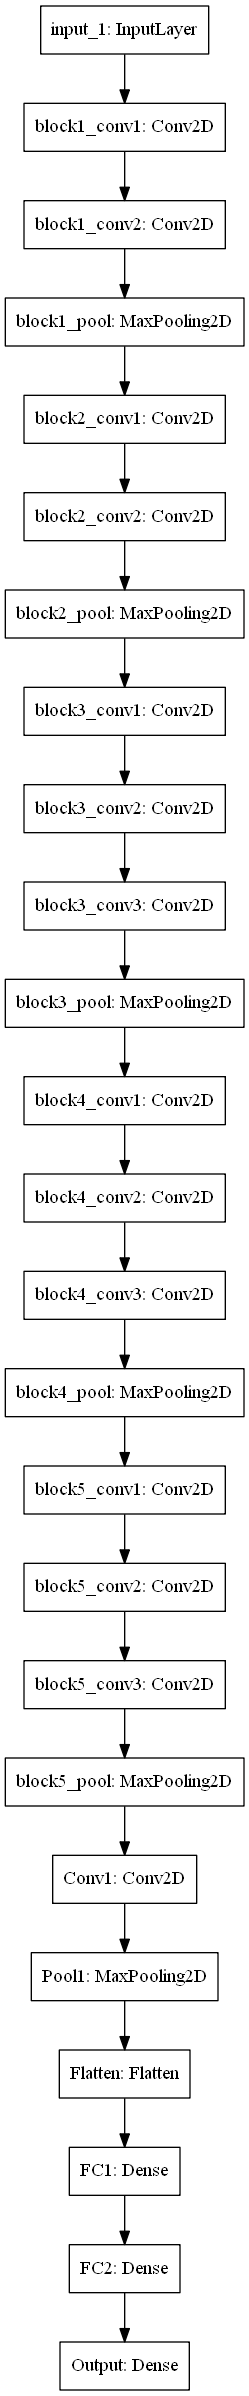

In [9]:
from tensorflow import keras
from keras.utils.vis_utils import plot_model
from keras.utils import np_utils

keras.utils.plot_model(model1, to_file='model1.png', show_layer_names=True)

### Callbacks:

In [10]:
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.callbacks import TensorBoard

checkpoint = ModelCheckpoint("gesturenew.h5", monitor='accuracy', verbose=1,
    save_best_only=True, mode='auto', period=1)

reduce = ReduceLROnPlateau(monitor='accuracy', factor=0.2, patience=5, min_lr=0.00001, verbose = 1)

logdir='logsgesture'
tensorboard_Visualization = TensorBoard(log_dir=logdir, histogram_freq=True)

### Compile the Model:

In [11]:
model1.compile(loss='categorical_crossentropy',
              optimizer=Adam(lr=0.001),
              metrics=['accuracy']
              )

### Fit The Model:

In [12]:
train_samples = 9600
validation_samples = 2400

epochs = 50

batch_size = 128

model1.fit(train_generator,
           steps_per_epoch = train_samples//batch_size,
           epochs = epochs,
           callbacks = [checkpoint, reduce, tensorboard_Visualization],
           validation_data = validation_generator,
           validation_steps = validation_samples//batch_size)

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 75 steps, validate for 18 steps
Epoch 1/50
74/75 [============================>.] - ETA: 1s - loss: 0.7919 - accuracy: 0.6913
Epoch 00001: accuracy improved from -inf to 0.69385, saving model to gesturenew.h5
75/75 [==============================] - 110s 1s/step - loss: 0.7866 - accuracy: 0.6939 - val_loss: 0.4173 - val_accuracy: 0.8485
Epoch 2/50
74/75 [============================>.] - ETA: 0s - loss: 0.3230 - accuracy: 0.8842
Epoch 00002: accuracy improved from 0.69385 to 0.88427, saving model to gesturenew.h5
75/75 [==============================] - 83s 1s/step - loss: 0.3222 - accuracy: 0.8843 - val_loss: 0.2452 - val_accuracy: 0.9214
Epoch 3/50
74/75 [============================>.] - ETA: 0s - loss: 0.2451 - accuracy: 0.9142
Epoch 00003: accuracy improved from 0.88427 to 0.91417, saving model to gesturenew.h5
75/75 [==============================] - 82s 1s/step - loss: 0.2446 - accuracy: 0.9142 - val_loss: 0.2105 - val_

### Graph:

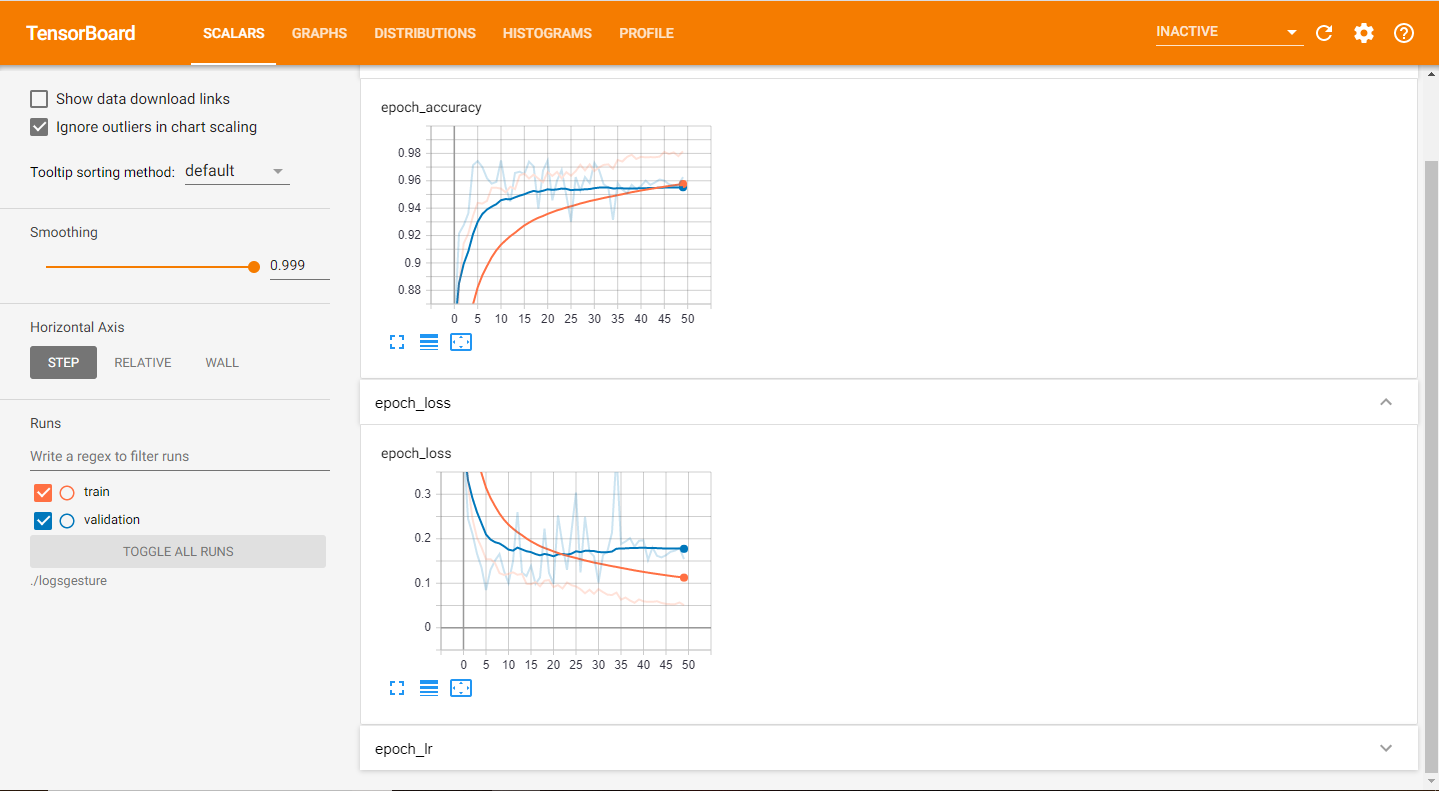

In [14]:
"""
    To access the logs and graphs type the below command in the
    command prompt :
    tensorboard --logdir="./logs1"
    
    Copy the URL link given and go the location to see the graphs
    via the local system.
    
    Below is a screenshot of the the graphs from Tensorboard.

"""

from IPython.display import Image 

pil_img = Image(filename='graphnew.png')
display(pil_img)

### The Model is able to perform extremely well. We can notice that the train and validation losses are decreasing constantly and the train as well as validation accuracy increases constantly. There is no overfitting in the deep learning model and we are able to achieve an validation accuracy of over 95%.